# **Night Sky Object Identification and Mapping**

In [37]:
import numpy as np
import random
import cv2
import math
from typing import List, Tuple
import matplotlib.pyplot as plt
import os
import shutil
import glob
import torch
import torchvision
from torch.utils.data import Dataset
from PIL import Image
import string
import torch.nn as nn

#TO DO LIST


*   Fix noise generation. DONE
*   Made star blur scaleas a sqrt. DONE
*   Fix higher magnification resulting in overly blurry images and small number of stars. DONE WITH PREVIOUS
*   Work on object generation. DONE
*   Pull the coordinates out of the data so we add them manually DONE
*   Create a way to tell the code tat you want n images of a certain object and have the code correctly make images. DONE
*   Automatic signal to noise ratio. DONE
*   Make a way to chek if the motion of the object will be visible. DONE
*   Add this check to automatic image generation somehow. DONE
*   Try doing a binary classifier to see if a CNN can identify moving object. DONE
*   Add random direction to data generation



#Calculating images

##Star code

In [38]:
stars_per_magnitude = {
    2.0: 48,
    3.0: 171,
    4.0: 513,
    5.0: 1602,
    6.0: 4800,
    7.0: 14000,
    8.0: 42000,
    9.0: 121000,
    10.0: 340000,
    11.0: 725346,
    12.0: 1374412,
    13.0: 2378009,
    14.0: 3844017,
    15.0: 5894386,
    16.0: 8665135,
    17.0: 12306357,
    18.0: 16982212,
    19.0: 22870933,
    20.0: 30164822, #used regression to find those above 20
    21.0: 3.997534295069156e7,
    22.0: 5.192083183249308e7,
    23.0: 6.6644844115279734e7,
    24.0: 8.462953308674893e7,
    25.0: 1.0641478627977826e8,
    26.0: 1.3260229977121532e8,
    27.0: 1.6385975616052195e8,
    28.0: 2.009251045589161e8,
}

def count_stars_in_range(start_magnitude: float, end_magnitude: float):
    total_stars = 0
    for magnitude in range(int(start_magnitude), int(end_magnitude) + 1):
        total_stars += stars_per_magnitude.get(magnitude, 0)
    return total_stars

def generate_stars(min_magnitude, percent_of_sky):
    # Number of stars to generate
    num_stars = int(count_stars_in_range(0, min_magnitude) * percent_of_sky)

    # List to hold the ranges of magnitudes
    magnitude_ranges = [(i, i+1, count_stars_in_range(i, i+1)*percent_of_sky) for i in range(0, min_magnitude)]

    stars = []
    for _ in range(num_stars):
        # Generate a random number to determine the magnitude bracket
        rand_number = random.random() * num_stars

        # Determine the bracket the random number falls into
        total = 0
        for mag_range in magnitude_ranges:
            total += mag_range[2]
            if rand_number <= total:
                break

        # Assign a magnitude to the star within the selected range
        magnitude = random.uniform(mag_range[0], mag_range[1])

        # Assign random coordinates to the star
        coord_x = random.random() * 100  # Percentage from left to right
        coord_y = random.random() * 100  # Percentage from bottom to top

        # Append the star (represented as a dictionary) to the list
        stars.append({"magnitude": magnitude, "coordinates": (coord_x, coord_y)})

    return stars

def add_diffraction_spikes(image, center, brightness, magnitude, magnitude_threshold, num_spikes, glow_radius):
    # Only add spikes to stars brighter than a certain threshold
    if magnitude > magnitude_threshold:
        return image

    # Define the base spike length
    base_spike_length = 2 * glow_radius

    # Calculate a factor to increase the spike length based on the star's magnitude
    magnitude_factor = 1.2 ** (magnitude_threshold - magnitude)

    # Calculate the final spike length including the magnitude factor
    final_spike_length = int(base_spike_length * magnitude_factor)

    # Add the spikes
    for i in range(num_spikes):
        # Calculate the direction of the spike
        angle = 2 * math.pi * i / num_spikes
        direction = (math.cos(angle), math.sin(angle))

        # Draw the spike on the image pixel by pixel
        for j in range(final_spike_length):
            position = (
                int(center[0] + direction[0] * j),
                int(center[1] + direction[1] * j)
            )
            # Fade brightness in the latter half of the spike
            if j >= final_spike_length / 2:
                pixel_brightness = brightness * (1 - 2 * (j - final_spike_length / 2) / final_spike_length)
            else:
                pixel_brightness = brightness

            # Check if the position is within the image boundaries before setting the pixel value
            if 0 <= position[0] < image.shape[1] and 0 <= position[1] < image.shape[0]:
                image[position[1], position[0]] = min(255, image[position[1], position[0]] + int(pixel_brightness))

    return image

def create_star_image(stars, celestial_object, celestial_object_position, image_size, exposure_time, magnitude_threshold, num_spikes):
    # Create a black image
    image = np.zeros(image_size, dtype=np.uint8)

    # Check if the list of stars is empty
    if not stars and not celestial_object:
        return image  # Return an empty image

    # Add the celestial object to the stars list with the given position
    if celestial_object: # only add if celestial_object is not empty
        stars = stars + [{'magnitude': celestial_object['magnitude'], 'coordinates': celestial_object_position}]

    # Calculate the maximum and minimum star magnitude
    min_magnitude = min(star['magnitude'] for star in stars)
    max_magnitude = max(star['magnitude'] for star in stars)

    # List to store the stars that need diffraction spikes
    stars_with_spikes = []

    # Map each star onto the image
    for star in stars:
        if celestial_object and star['magnitude'] == celestial_object['magnitude'] and star['coordinates'] == celestial_object_position:
            continue  # Skip the celestial object

        # Calculate star brightness
        if max_magnitude == min_magnitude:
            brightness = 255
        else:
            brightness = int(((max_magnitude - star['magnitude']) / (max_magnitude - min_magnitude)) * 255)

        # Calculate the position of the star in the image
        position = (int(star['coordinates'][1] / 100 * image_size[1]),
                    int(star['coordinates'][0] / 100 * image_size[0]))

        # Add a glow around the star
        glow_radius = calculate_glow_radius(star['magnitude'], max_magnitude, exposure_time)
        image = add_glow(image, position, brightness, glow_radius)

        # Set the pixel at the star's position to the star's brightness
        image[position[1], position[0]] = min(255, image[position[1], position[0]] + brightness)

        # Add star to the list of stars that need diffraction spikes if it meets the magnitude threshold
        if star['magnitude'] <= magnitude_threshold:
            stars_with_spikes.append((position, brightness, star['magnitude'], glow_radius))

    # Add diffraction spikes around the stars
    for position, brightness, magnitude, glow_radius in stars_with_spikes:
        image = add_diffraction_spikes(image, position, brightness, magnitude, magnitude_threshold, num_spikes, glow_radius)

    return image


def calculate_glow_radius(star_magnitude, max_magnitude, exposure_time):
    base_magnitude = 0  # or another value to scale the radius
    relative_magnitude = max_magnitude - star_magnitude
    # calculate base 10 logarithm of relative brightness, and scale it by a factor
    glow_radius = int(0.1 * np.log10(2.5**relative_magnitude) * np.sqrt(exposure_time))  # Using square root of exposure time
    return glow_radius


def add_glow(image, center, brightness, radius):
    # Calculate the square area to consider for the glow
    min_x = max(0, center[0] - radius)
    max_x = min(image.shape[1], center[0] + radius)
    min_y = max(0, center[1] - radius)
    max_y = min(image.shape[0], center[1] + radius)

    # Iterate over the area and add the glow
    for x in range(min_x, max_x):
        for y in range(min_y, max_y):
            # Calculate the distance to the center of the glow
            distance = np.sqrt((x - center[0])**2 + (y - center[1])**2)

            # Calculate the glow brightness
            glow_brightness = int(brightness * (1 - distance / radius))
            glow_brightness = max(0, glow_brightness)  # make sure the brightness never goes below zero

            # Add the glow to the pixel
            if (y, x) == center:
                image[y, x] = glow_brightness
            else:
                image[y, x] = min(255, image[y, x] + glow_brightness)

    return image

##Object code

In [39]:
def distribute_brightness(image, position, magnitude, angular_size_deg, fov_deg, image_size, exposure_time, aperture_diameter):
    imageTemp = image.copy()

    # Calculate the brightness using exposure time and aperture
    C = 255 * 10 ** -0.4  # Astronomical Magnitude System constant
    brightness = C * exposure_time * aperture_diameter**2 * 10 ** (-0.4 * magnitude)

    # Convert angular size in degrees to radius in pixels
    radius_pixels = angular_size_deg / fov_deg * image_size[0] / 2

    # Define a temporary array to store the added brightness
    added_brightness = np.zeros_like(image, dtype=float)

    # Check every pixel
    for x in range(image_size[0]):
        for y in range(image_size[1]):
            dx, dy = x - position[0], y - position[1]
            distance = math.hypot(dx, dy)

            if distance > radius_pixels:
                continue  # Pixel is outside the object

            # Calculate the proportion of the pixel covered by the object
            if distance + 1 < radius_pixels:
                proportion = 1  # Pixel is completely inside the object
            else:
                # Pixel is partially inside the object.
                # We approximate the proportion using a linear model (which is a rough approximation)
                proportion = 1 - (distance + 0.5 - radius_pixels)

            # Add the brightness to the pixel
            added_brightness[y, x] += proportion * brightness / (math.pi * radius_pixels**2)

            # Set pixel brightness within object to 0 in the original image
            imageTemp[y, x] = 0

    # Normalize the brightness so that the maximum added brightness is 255
    max_added_brightness = added_brightness.max()
    if max_added_brightness > 0:
        added_brightness *= 255 / max_added_brightness

    # Add the additional brightness to the image, but don't exceed 255
    imageTemp = np.minimum(255, imageTemp + added_brightness)

    return imageTemp

def can_image_planet(planet_properties, fov_degrees, n_images, time_per_image, is_moving_left_to_right):
    # Constants
    gravitational_constant = 6.67430e-11  # m^3 kg^-1 s^-2
    solar_mass = 1.98847e30  # kg
    AU_to_meters = 1.495978707e11  # 1 AU in meters

    # Extract the semi-major axis in AU and convert it to meters
    sma_meters = planet_properties['sma_AU'] * AU_to_meters

    # Use Kepler's Third Law to compute the orbital period (in seconds)
    orbital_period = 2 * math.pi * math.sqrt(sma_meters**3 / (gravitational_constant * solar_mass))

    # Convert the orbital period to degrees per second
    degrees_per_second = 360 / orbital_period

    # Compute the total time span of the image sequence
    total_time = n_images * time_per_image

    # Compute the total angle covered by the planet during this time
    total_angle = total_time * degrees_per_second

    # Check whether this total angle would fit within the field of view of the camera
    if total_angle > fov_degrees:
        return 0

    # Calculate the path width as a percentage of the field of view
    path_width_percent = total_angle / fov_degrees * 100

    return path_width_percent


def add_object_to_image(image, planet_properties, coordinates, fov_deg, exposure_time, aperture_diameter):
    image_size = image.shape

    # Convert from percent to pixels
    object_coordinates_pixels = (int(coordinates[0] / 100 * image_size[1]),
                                 int(coordinates[1] / 100 * image_size[0]))

    # Calculate the angular size
    angle = angular_size(planet_properties['diameter_km'], planet_properties['sma_AU']*1.496e11)

    # Add the object to the image
    image_with_object = distribute_brightness(image, object_coordinates_pixels, planet_properties['magnitude'], angle, fov_deg, image_size, exposure_time, aperture_diameter)

    return image_with_object

def add_object_to_stars(stars, object_coordinates, object_magnitude):
    # Create a dictionary representing the object (similar to how the stars are represented)
    object_dict = {"magnitude": object_magnitude, "coordinates": object_coordinates}

    # Append the object to the stars list
    stars.append(object_dict)

    return stars

import matplotlib.pyplot as plt
import random

def create_and_save_images(starsToUse, exposure_time, minMagnitude, aperture, planet_properties=None, fov=None, n_images=1, time_per_image=1, is_moving_left_to_right=True, n_of_spikes=0, image_size=100, noiseToSignalRatio=1, explicitVisibleMotion=False, save_dir="images"):

    # If planet_properties is provided, calculate magnitude and check if it's possible to image the planet
    if planet_properties:
        planet_properties['magnitude'] = calculate_apparent_magnitude(
            planet_properties['sma_AU'],
            planet_properties['diameter_km'],
            planet_properties['albedo']
        )

        # Check if it's possible to image the planet and get the start and end ranges
        pathWidth = can_image_planet(planet_properties, fov, n_images, time_per_image, is_moving_left_to_right)

        if (not pathWidth and explicitVisibleMotion):
            print("Cannot create images.")
            return

        degrees_per_step = (pathWidth / n_images)
        randY = random.uniform(0, 100)
        start_position = random.uniform(0, 100 - pathWidth) if is_moving_left_to_right else random.uniform(pathWidth, 100)

        if explicitVisibleMotion and not can_see_motion(fov, planet_properties['sma_AU'], time_per_image, image_size, start_position/100):
            start_position = int(start_position) + 0.99
            if not can_see_motion(fov, planet_properties['sma_AU'], time_per_image, image_size, start_position/100):
                print("Cannot create images due to explicit object visibility requirements.")
                return
    else:
        degrees_per_step = 0
        randY = 0
        start_position = 0

    image_size = (image_size, image_size)

    # Create and save images
    for i in range(n_images):
        # Calculate the current position of the planet
        current_position = (start_position + i * degrees_per_step) if is_moving_left_to_right else (start_position - i * degrees_per_step)

        # Define the coordinates of the planet in the image
        coords = (current_position, randY)  # Assuming calculate_coords is a function you have

        # Create image without noise
        imageNoNoise = create_star_image(starsToUse, planet_properties, coords, image_size, exposure_time, 0.75 * minMagnitude, n_of_spikes)

        # Add the object to the image if planet_properties is provided
        if planet_properties:
            image_with_object = add_object_to_image(imageNoNoise, planet_properties, coords, fov, exposure_time, aperture/1000)
        else:
            image_with_object = imageNoNoise

        # Combine images with noise
        imageNoise = combine_images_with_noise(image_with_object, noiseToSignalRatio)

        # Save the image
        plt.figure(figsize=(10, 10))
        plt.imsave(f'{save_dir}/star_image_{i+1}_of_{n_images}.png', imageNoise, cmap='gray')
        plt.close()


In [40]:
def angular_size(diameter_km, sma_m):
    # Convert diameter to meters
    diameter_m = diameter_km * 1e3

    # Calculate angular size in radians
    A_rad = diameter_m / sma_m

    # Convert to degrees
    A_deg = math.degrees(A_rad)

    return A_deg

def calculate_apparent_magnitude(dBS, D, p):
    dBO = dBS - 1

    # Calculate the absolute magnitude using albedo and diameter of the planet
    H = 5*math.log10(1329/(D*math.sqrt(p)))

    # Calculate the distance between the observer and the Sun
    dOS = math.sqrt(dBS**2 + dBO**2 - 2*dBS*dBO)

    # Calculate the apparent magnitude
    m = H + 5*math.log10(dBS*dBO/(dOS**2)) + 0.44022814763920315

    return m

def calculate_spatial_data(fov_deg: float, position_data: List[Tuple[float, Tuple[int, int]]], diameter: float, image_width: int) -> None:
    # convert fov to radians
    fov_rad = math.radians(fov_deg)
    G = 6.67430e-11  # gravitational constant in m^3 kg^-1 s^-2
    M_sun = 1.989e30  # mass of the sun in kg
    time_difference = position_data[-1][0] - position_data[0][0]

    sum_square_diff = 0
    last_angle = None
    for data in position_data:
        time, position = data
        angle = tuple(math.radians(coord / 100 * fov_deg) for coord in position)

        if last_angle is not None:
            dx = angle[0] - last_angle[0]
            dy = angle[1] - last_angle[1]
            sum_square_diff += dx**2 + dy**2
        last_angle = angle

    total_angular_movement_rad = math.sqrt(sum_square_diff)
    print(f"The object moved {math.degrees(total_angular_movement_rad)} degrees.")

    # Calculate the total time for a full 2pi radian orbit
    orbital_period_hours = (2*math.pi / total_angular_movement_rad) * time_difference / 3600
    print(f"The estimated orbital period is {orbital_period_hours} hours.")

    # Calculate the semi-major axis using Kepler's third law
    orbital_period_seconds = orbital_period_hours * 3600  # convert period to seconds
    sma = ((G * M_sun * orbital_period_seconds**2) / (4 * math.pi**2))**(1/3)
    print(f"The estimated semi-major axis is {sma} meters.")

    # Calculate the angular size
    A_deg = angular_size(diameter, sma)
    pixelWidth = (image_width / fov_deg)*A_deg # Image width in pixels.
    print(f"The estimated angular size is {A_deg} degrees - which should be {pixelWidth} pixels wide.")

In [41]:
def can_see_motion(fov, object_distance, time_between_images, image_dim, start_position):
    """
    Determine whether an object's motion would be visible as a movement of at least one pixel
    between two images taken with a given time difference.

    Parameters:
    - fov: field of view of the camera (degrees)
    - object_distance: distance to the object (km)
    - time_between_images: time between the two images (seconds)
    - image_dim: the dimensions of the image (in pixels)

    Returns:
    - True if the object moves at least one pixel, otherwise False.
    """
    # Constants
    gravitational_constant = 6.67430e-11  # m^3 kg^-1 s^-2
    solar_mass = 1.98847e30  # kg
    AU_to_km = 1.496e8  # 1 AU in kilometers

    # Convert object distance to meters and calculate orbital period using Kepler's third law
    object_distance_m = object_distance * AU_to_km * 1000
    orbital_period = 2 * math.pi * math.sqrt(object_distance_m**3 / (gravitational_constant * solar_mass))

    # Calculate the angular speed of the object (in degrees per second)
    angular_speed = 360 / orbital_period

    # Calculate the distance covered by the object in the time between the two images (in degrees)
    distance_covered = angular_speed * time_between_images

    # Calculate the size of a pixel (in degrees)
    pixel_size = fov / image_dim

    # If the distance covered is greater than the size of a pixel, the object has moved at least one pixel
    return (start_position*fov+distance_covered)/pixel_size>int(start_position*fov/pixel_size+2)

t= 30000
can_see_motion(0.4392, 9.582, t, 100, 0.50)

True

## Noise code

In [42]:
import numpy as np

def generate_noise_image(image_shape):
    # Generate a random noise image with pixel values in the range [0, 255]
    return np.random.randint(0, 256, image_shape, dtype=np.uint8)

def combine_images_with_noise(image, signal_to_noise_ratio):
    # Convert the image to float to avoid overflow or underflow
    image = np.array(image, dtype=np.float64)

    # Generate a noise image of the same shape as the input image
    noise_image = generate_noise_image(image.shape)

    # Convert the noise image to float
    noise_image = np.array(noise_image, dtype=np.float64)

    # Handle the case where the signal-to-noise ratio is between 0 and 1
    if signal_to_noise_ratio < 1:
        # Create an array of "noise" images and one "good" image
        images = [noise_image] * int(1/signal_to_noise_ratio) + [image]

    # Handle the case where the signal-to-noise ratio is an integer or greater than 1
    else:
        # Split the signal-to-noise ratio into an integer part and a fractional part
        integer_part = int(signal_to_noise_ratio)
        fractional_part = signal_to_noise_ratio - integer_part

        # Create an array of "good" images and one "noise" image
        images = [image] * integer_part + [image*fractional_part, noise_image]

    # Combine the images by calculating their mean
    combined_image = np.mean(images, axis=0)

    # Make sure the image intensity stays within the valid range
    combined_image = np.clip(combined_image, 0, 255)

    # Convert the image back to the original datatype
    combined_image = np.array(combined_image, dtype=np.uint8)

    return combined_image

def calculate_snr(aperture_mm, exposure_time, focal_ratio, fov_degrees):
    # Convert aperture from mm to meters
    aperture_m = aperture_mm / 1000

    # Compute the value as per your formula
    snr = math.sqrt((aperture_m ** 2 * math.pi) * (fov_degrees / focal_ratio) * (exposure_time ** 1.46))

    return snr

def calculate_exposure_time(aperture_mm, snr, focal_ratio, fov_degrees):
    # Convert aperture from mm to meters
    aperture_m = aperture_mm / 1000

    # Compute the exposure time as per the rearranged formula
    exposure_time = (snr ** 2 / ((aperture_m ** 2 * math.pi) * (fov_degrees / focal_ratio))) ** (1 / 1.46)

    return exposure_time

##Telescope code

In [43]:
def field_of_view(chip_size_mm: float, focal_length_mm: float) -> float:
    # Formula for field of view in arcminutes, considering focal length in mm
    fov = (57.3 * chip_size_mm) / focal_length_mm
    return fov

def check_star_visibility(aperture: float, exposure_time: float):
    # Define parameters
    max_brightness = 255  # Maximum star brightness (8-bit scale)
    magnitude_buckets = create_magnitude_buckets(2, 28)

    # Check star visibility
    for min_magnitude, max_magnitude in magnitude_buckets:  # iterate over each magnitude bucket from dimmest to brightest
        # Determine star brightness based on exposure time and aperture
        brightness = 10 ** (-max_magnitude / 2.5)  # generate a star at the dimmest edge of the current bucket

        # Adjust brightness according to exposure time and aperture
        exposure_factor = exposure_time  # The longer the exposure time, the more light is collected
        aperture_factor = aperture**2  # The effectiveness of aperture is proportional to the square of its diameter
        brightness *= exposure_factor * aperture_factor

        # Make sure brightness is within acceptable limits
        brightness = np.clip(brightness, 0, max_brightness)

        # If the star is bright enough to be seen, record it
        if brightness > 1:  # or whatever threshold you deem appropriate
            return max_magnitude
            break  # Breaks the loop as soon as we find a visible star, assuming all brighter stars are also visible


def create_magnitude_buckets(min_magnitude: int, max_magnitude: int):
    return [(i, i+1) for i in range(max_magnitude-1, min_magnitude-1, -1)]

##Telescope settings

In [44]:
aperture=240
focal_len=3000
exposure_time= 60*5
chip_size = 23
fov = field_of_view(chip_size, focal_len)
fov2 = fov*fov
percentOfSky = ((fov2)/41253)
snr = calculate_snr(aperture, exposure_time, focal_len/aperture, fov)
print(f"FoV = {fov} degrees which is {fov2} degrees squared or {percentOfSky} % of night sky.")
print(f"SNR = {snr}")
minMagnitude = check_star_visibility(aperture, exposure_time)
print(minMagnitude)
print(count_stars_in_range(0, minMagnitude)*percentOfSky)

FoV = 0.43929999999999997 degrees which is 0.19298448999999998 degrees squared or 4.678071655394758e-06 % of night sky.
SNR = 5.128735346438478
18
246.50634523394464


In [45]:
stars = generate_stars(minMagnitude, percentOfSky)

#Generating images

### Raw data of some planets and telescopes

#### Telescopes

In [46]:
telescopes = {
    'Alpha': {
        'aperture': 240,
        'focal_len': 3000,
        'chip_size': 23
    },
    'Beta': {
        'aperture': 200,
        'focal_len': 2500,
        'chip_size': 22
    },
    'Gamma': {
        'aperture': 300,
        'focal_len': 3500,
        'chip_size': 24
    },
    'Delta': {
        'aperture': 260,
        'focal_len': 3200,
        'chip_size': 23.5
    },
    'Epsilon': {
        'aperture': 280,
        'focal_len': 3300,
        'chip_size': 24.5
    },
    'Zeta': {
        'aperture': 100,
        'focal_len': 1000,
        'chip_size': 18
    },
    'Eta': {
        'aperture': 80,
        'focal_len': 900,
        'chip_size': 16
    },
    'Theta': {
        'aperture': 120,
        'focal_len': 1300,
        'chip_size': 20
    },
    'Keck': {  # Keck Observatory
        'aperture': 10000,  # 10 meters
        'focal_len': 175000,  # Corrected
        'chip_size': 50
    },
    'VLT': {  # Very Large Telescope
        'aperture': 8200,  # 8.2 meters
        'focal_len': 160000,  # Corrected
        'chip_size': 45
    },
    'Hubble': {  # Hubble Space Telescope
        'aperture': 2400,  # 2.4 meters
        'focal_len': 57600,  # Corrected
        'chip_size': 38
    },
    'ELT': {  # Extremely Large Telescope
        'aperture': 39300,
        'focal_len': 743400,
        'chip_size': 120
    },
    'Skywatcher': {  # Sky-Watcher Evostar 72
        'aperture': 72,
        'focal_len': 420,
        'chip_size': 14
    },
    'Celestron': {  # Celestron NexStar 8 SE
        'aperture': 200,
        'focal_len': 2000,
        'chip_size': 22
    },
    'Orion': {  # Orion StarBlast II 4.5 EQ
        'aperture': 114,
        'focal_len': 450,
        'chip_size': 15
    },
}

#### Planets

In [47]:
planets = {
    'jupiter': {
        'albedo': 0.52,
        'diameter_km': 139820,
        'sma_AU': 5.204
    },
    'saturn': {
        'albedo': 0.47,
        'diameter_km': 116460,
        'sma_AU': 9.582
    },
    'mars': {
        'albedo': 0.15,
        'diameter_km': 6779,
        'sma_AU': 1.524
    },
    'uranus': {
        'albedo': 0.51,
        'diameter_km': 50724,
        'sma_AU': 19.18
    },
    'neptune': {
        'albedo': 0.41,
        'diameter_km': 49244,
        'sma_AU': 30.07
    },
    'pluto': {
        'albedo': 0.3,
        'diameter_km': 2376,
        'sma_AU': 39.48
    },
    'ceres': {
        'albedo': 0.09,
        'diameter_km': 939.4,
        'sma_AU': 2.766
    },
    'vesta': {
        'albedo': 0.4228,
        'diameter_km': 525.4,
        'sma_AU': 2.362
    },
    'pallas': {
        'albedo': 0.1587,
        'diameter_km': 511,
        'sma_AU': 2.772
    },
    'hygiea': {
        'albedo': 0.0717,
        'diameter_km': 433,
        'sma_AU': 3.137
    },
    'interamnia': {
        'albedo': 0.0742,
        'diameter_km': 332,
        'sma_AU': 3.062
    },
    'davida': {
        'albedo': 0.054,
        'diameter_km': 298,
        'sma_AU': 3.166
    },
    'sylvia': {
        'albedo': 0.0435,
        'diameter_km': 271,
        'sma_AU': 3.489
    },
    'eunomia': {
        'albedo': 0.2094,
        'diameter_km': 270,
        'sma_AU': 2.644
    },
    'euphrosyne': {
        'albedo': 0.0543,
        'diameter_km': 268,
        'sma_AU': 3.149
    },
    'cybele': {
        'albedo': 0.0706,
        'diameter_km': 263,
        'sma_AU': 3.433
    },
    'hektor': {
        'albedo': 0.025,
        'diameter_km': 256,
        'sma_AU': 5.229
    },
    'juno': {
        'albedo': 0.2383,
        'diameter_km': 254,
        'sma_AU': 2.668
    }
}

### Generate more

In [85]:
def generate_objects(data, num_objects):
    for _ in range(num_objects):
        # Select two random keys from the dictionary
        obj1, obj2 = random.sample(list(data.keys()), 2)

        # Create a new object which is the average of the two selected objects
        new_obj = {key: (data[obj1][key] + data[obj2][key]) / 2 for key in data[obj1].keys()}

        # Generate a random string of 10 letters for the new object name
        new_obj_name = ''.join(random.choices(string.ascii_lowercase, k=10))

        # Add the new object to the data dictionary
        data[new_obj_name] = new_obj
    return data

In [93]:
planets = generate_objects(planets, 300)
telescopes = generate_objects(telescopes, 300)

### Automatic image generation

In [15]:
def settupAndGeneration(planets, telescopes, dims, snrRange, visiblePlanet):
    # Select a random telescope
    telescope_name, telescope_properties = random.choice(list(telescopes.items()))

    # Extract the properties of the selected telescope
    aperture = telescope_properties['aperture']
    focal_len = telescope_properties['focal_len']
    chip_size = telescope_properties['chip_size']

    # Calculate additional parameters
    fov = field_of_view(chip_size, focal_len)
    snr = random.uniform(snrRange[0], snrRange[1])
    exposure_time = calculate_exposure_time(aperture, snr, focal_len/aperture, fov)
    minMagnitude = check_star_visibility(aperture, exposure_time)
    fov2 = fov * fov
    percentOfSky = ((fov2)/41253)
    stars = generate_stars(minMagnitude, percentOfSky)

    # Based on whether the image contains a planet or not, choose the directory to save in
    save_dir = 'imagesForTraining/planets' if visiblePlanet else 'imagesForTraining/no_planets'

    # Set number of images and time per image
    n_images = 2
    time_per_image = 100000  # Initial time per image

    if visiblePlanet:
        # Select a random planet
        planet_name, planet_properties = random.choice(list(planets.items()))
        # Update planet_properties with magnitude
        planet_properties['magnitude'] = calculate_apparent_magnitude(
            planet_properties['sma_AU'],
            planet_properties['diameter_km'],
            planet_properties['albedo']
        )

        # Try to create images and reduce the time per image if it fails
        while True:
            path_width = can_image_planet(planet_properties, fov, n_images, time_per_image, True)
            if path_width != 0:  # If images can be created
                create_and_save_images(stars, exposure_time, minMagnitude, aperture, planet_properties, fov, n_images, time_per_image, True, 0, dims, snr, True, save_dir)
                break
            else:
                randReduction = random.uniform(1, 4)
                time_per_image /= randReduction  # Reduce the time per image by a random value - to create more realistic data.
    else:
        planet_name = "NoPlanet"
        planet_properties = {}
        create_and_save_images(stars, exposure_time, minMagnitude, aperture, planet_properties, fov, n_images, 0, True, 0, dims, snr, False, save_dir)

    # Rename and move the images
    for j in range(n_images):
        old_name = f'{save_dir}/star_image_{j+1}_of_{n_images}.png'
        if os.path.isfile(old_name):
            new_name = f'{planet_name}_{telescope_name}_{exposure_time}_{j+1}_of_{n_images}.png'
            os.rename(old_name, new_name)
            shutil.move(new_name, save_dir)

def generate_images(planets, telescopes, n, dims, percentageWithPlanets, deleteDirectory, snrRange):
    # Create directory if it doesn't exist
    if not os.path.exists('imagesForTraining'):
        os.makedirs('imagesForTraining')
        os.makedirs('imagesForTraining/planets')
        os.makedirs('imagesForTraining/no_planets')
    else:
        # If the directory exists, delete all images in it if the delete direct argument was passed as True
        if deleteDirectory:
          files = glob.glob('imagesForTraining/no_planets/*.png')
          for f in files:
              os.remove(f)
          files = glob.glob('imagesForTraining/planets/*.png')
          for f in files:
              os.remove(f)

    for i in range(int(n*percentageWithPlanets)):
        settupAndGeneration(planets, telescopes, dims, snrRange, visiblePlanet=True)

    for i in range(int(n*percentageWithPlanets), n):
        settupAndGeneration(planets, telescopes, dims, snrRange, visiblePlanet=False)

In [ ]:
generate_images(planets, telescopes, n=12000, dims=100, percentageWithPlanets=0.5, deleteDirectory=True, snrRange=(3,6))

### Manual image generation

In [ ]:
# Choose which planet to simulate
selected_planet = 'jupiter'  # Change this to the planet you want

# Extract the properties of the selected planet
planet_properties = planets[selected_planet]

n_images = 2
time_per_image = 0
explicitVisibleMotion = False
imageDims = 850
create_and_save_images(stars, exposure_time, minMagnitude, aperture, planet_properties, fov, n_images, time_per_image, True, 0, imageDims, snr, explicitVisibleMotion)

Cannot create images.


##Saving images and working with files

In [ ]:
!rm -r starimg*
!mkdir starimg
!mv star_ima* starimg

In [ ]:
from google.colab import files
!zip -r /content/starimg.zip /content/starimg
files.download("/content/starimg.zip")

In [ ]:
!rm -r images*

In [ ]:
from google.colab import files
!rm images*.zip
!zip -r /content/imagesForTraining.zip /content/imagesForTraining
files.download("/content/imagesForTraining.zip")

In [ ]:
!rm -rf imagesFor*

# MODEL TESTING

#### Dependencies

In [25]:
!pip install torch torchvision torchviz tensorflow

#### Network 3 - Binary Class Working

In [17]:
class ChangeImageDataset(Dataset):
    def __init__(self, planets_folder, no_planets_folder, transform=None):
        self.planets_folder = planets_folder
        self.no_planets_folder = no_planets_folder
        self.transform = transform

        self.planets_images = sorted(os.listdir(planets_folder))  # sort filenames
        self.no_planets_images = sorted(os.listdir(no_planets_folder))

    def __len__(self):
        return len(self.planets_images) - 1 + len(self.no_planets_images) - 1

    def __getitem__(self, idx):
        if idx < len(self.planets_images) - 1:
            img_name_1 = os.path.join(self.planets_folder, self.planets_images[idx])
            img_name_2 = os.path.join(self.planets_folder, self.planets_images[idx + 1])
            label = 1
        else:
            idx = idx - (len(self.planets_images) - 1)
            img_name_1 = os.path.join(self.no_planets_folder, self.no_planets_images[idx])
            img_name_2 = os.path.join(self.no_planets_folder, self.no_planets_images[idx + 1])
            label = 0

        image1 = Image.open(img_name_1)
        image2 = Image.open(img_name_2)

        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)

        return torch.cat([image1, image2], dim=0), torch.tensor(label, dtype=torch.float32)



In [18]:
from torch.utils.data import DataLoader
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((100, 100)),  # Resize images
    transforms.Grayscale(),  # Convert to grayscale
    transforms.ToTensor()  # Convert PIL image to Torch tensor
])

dataset = ChangeImageDataset(
    planets_folder='imagesForTraining/planets',
    no_planets_folder='imagesForTraining/no_planets',
    transform=transform
)

# split dataset into training and validation
train_size = int(0.8 * len(dataset))  # 80% for training
valid_size = len(dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)


In [23]:
class ChangeNet(nn.Module):
    def __init__(self):
        super(ChangeNet, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(2, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten(),
            nn.Linear(256*12*12, 1024),  # Adjust based on the output size from the last MaxPool layer
            nn.ReLU(),
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.cnn(x)
        return torch.sigmoid(x).squeeze(1)


Epoch 5, Training Loss: 0.16596208802424373, Validation Loss: 0.20820294320583344
Accuracy of the network on the validation set: 90 %


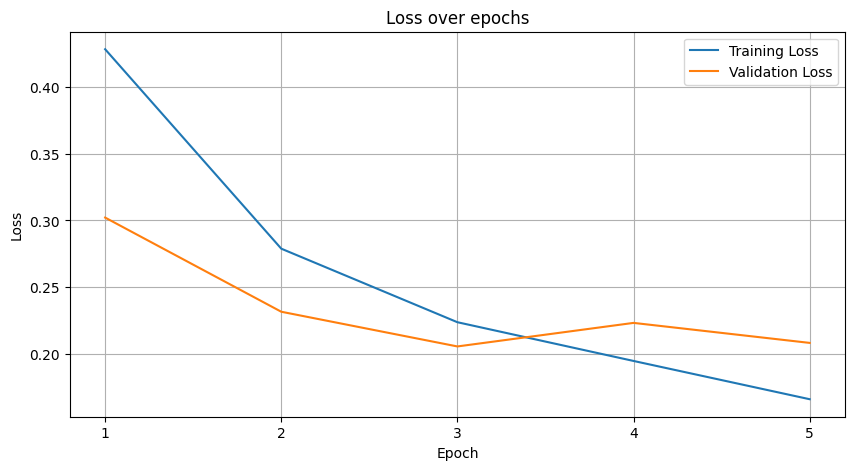

Early stopping!


In [98]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

model = ChangeNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.BCELoss()

epochs = 20
min_val_loss = float('inf')
epochs_no_improve = 0

train_losses = []
valid_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_fn(model(images).squeeze(), labels) for images, labels in valid_loader)
        valid_loss = valid_loss / len(valid_loader)
        valid_losses.append(valid_loss)

    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            outputs = model(images).squeeze()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Clear output and print current losses
    clear_output(wait=True)
    print(f'Epoch {epoch+1}, Training Loss: {train_losses[-1]}, Validation Loss: {valid_losses[-1]}')
    print('Accuracy of the network on the validation set: %d %%' % (100 * correct / total))

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epoch + 2), train_losses, label='Training Loss')
    plt.plot(range(1, epoch + 2), valid_losses, label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(range(1, epoch + 2))
    plt.legend()
    plt.grid(True)
    plt.show()

    # In your training loop
    if valid_loss < min_val_loss:
        min_val_loss = valid_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == 2:model.info()
            print('Early stopping!')
            break

In [36]:
from torchsummary import summary

model = ChangeNet()
summary(model, (2, 100, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 100, 100]           1,216
              ReLU-2         [-1, 64, 100, 100]               0
         MaxPool2d-3           [-1, 64, 50, 50]               0
            Conv2d-4          [-1, 128, 50, 50]          73,856
              ReLU-5          [-1, 128, 50, 50]               0
         MaxPool2d-6          [-1, 128, 25, 25]               0
            Conv2d-7          [-1, 256, 25, 25]         295,168
              ReLU-8          [-1, 256, 25, 25]               0
         MaxPool2d-9          [-1, 256, 12, 12]               0
          Flatten-10                [-1, 36864]               0
           Linear-11                 [-1, 1024]      37,749,760
             ReLU-12                 [-1, 1024]               0
           Linear-13                  [-1, 128]         131,200
             ReLU-14                  [